<a href="https://colab.research.google.com/github/mohammadsanaee/DeepLearningCourse/blob/main/hw03_mohammadsanaeev2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Lab assignment 02

### Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you. 

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* Transformer/CNN/<whatever you select> encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language models (for decoder and encoder)

* or just fine-tunning BART/ELECTRA/... ;)

to improve the translation quality. 

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [ ]:
# You might need to install the libraries below. Do it in the desired environment
# if you are working locally.

! pip  install subword-nmt
! pip install nltk
! pip install torchtext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
path_do_data = '../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = './data.txt'

Dataset not found locally. Downloading from github.
--2023-05-01 10:59:11--  https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12905334 (12M) [text/plain]
Saving to: ‘data.txt’

data.txt            100%[===================>]  12.31M  --.-KB/s    in 0.06s   

2023-05-01 10:59:11 (222 MB/s) - ‘data.txt’ saved [12905334/12905334]



In [ ]:
# Baseline solution BLEU score is quite low. Try to achieve at least __21__ BLEU on the test set. 
# The checkpoints are:

# * __21__ - minimal score to submit the homework, 30% of points

# * __25__ - good score, 70% of points

# * __27__ - excellent score, 100% of points

### Warning! The code below is deeeeeeeply deprecated and is is provided only as simple guide.
We suggest you to stick to most recent pipelines here, e.g. by Huggingface: 
* Example notebook: [link](https://github.com/huggingface/notebooks/blob/main/examples/translation.ipynb)
* Converting your own dataset to specific format: [link](https://discuss.huggingface.co/t/correct-way-to-create-a-dataset-from-a-csv-file/15686/15)

In [ ]:
!pip install torchtext==0.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.2 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.15.1
    Uninstalling torchtext-0.15.1:
      Successfully uninstalled torchtext-0.15.1


In [ ]:
# old deprecated code
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import TranslationDataset,Multi30k
from torchtext.data import Field, BucketIterator

import spacy

import random
import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE


### Main part
__Here comes the preprocessing. Do not hesitate to use BPE or more complex preprocessing ;)__

In [ ]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [ ]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

dataset = torchtext.data.TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [ ]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [ ]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [ ]:
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

In [ ]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 9176
Unique tokens in target (en) vocabulary: 6720


Here are tokens from original (RU) corpus:

In [ ]:
SRC.vocab.itos[::1000]

['<unk>',
 'закусок',
 'golden',
 'культурного',
 '82',
 'хай',
 'mendoza',
 'франческо',
 'елена',
 'уок']

And from target (EN) corpus:

In [ ]:
TRG.vocab.itos[::1000]

['<unk>', 'delivery', 'façade', 'clear', 'mariscal', 'specializes', 'mal']

And here is example from train dataset:

In [ ]:
print(vars(train_data.examples[9]))

{'trg': ['al', 'massira', 'airport', 'is', '31', 'km', 'away', '.'], 'src': ['аэропорт', 'аль', '-', 'массира', 'находится', 'в', '31', 'км', '.']}


Let's check the length distributions:

Length distribution in Train data


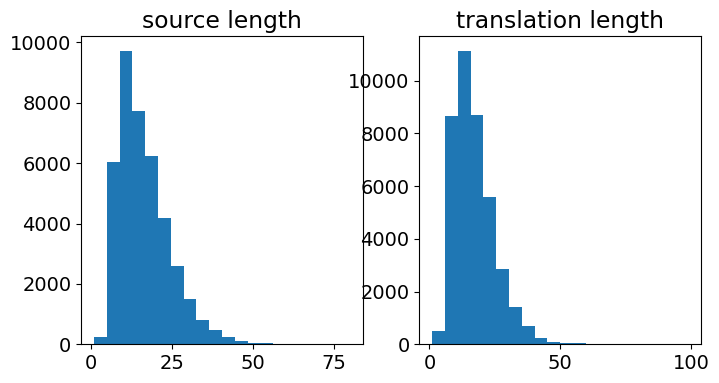

In [ ]:
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

Length distribution in Test data


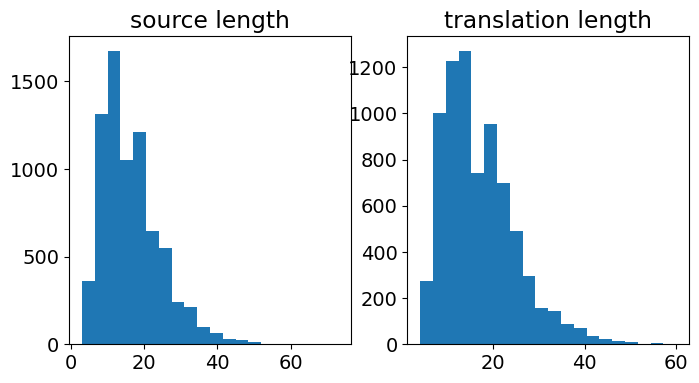

In [ ]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

### Model side
__Here comes simple pipeline of NMT model learning. It almost copies the week03 practice__

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda')

In [ ]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [ ]:
for x in train_iterator:
    break
print(x)
print(x.src.shape, x.trg.shape)


[torchtext.data.batch.Batch of size 128]
	[.trg]:[torch.cuda.LongTensor of size 54x128 (GPU 0)]
	[.src]:[torch.cuda.LongTensor of size 46x128 (GPU 0)]
torch.Size([46, 128]) torch.Size([54, 128])


In [ ]:
from torch import nn


class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        embedded = self.dropout(self.embedding(src))

        outputs, hidden = self.rnn(embedded)
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))

        return outputs, hidden

In [ ]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs):

        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]        
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)       
        encoder_outputs = encoder_outputs.permute(1, 0, 2)      
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        attention = self.v(energy).squeeze(2)

        return F.softmax(attention, dim=1)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs):

        input = input.unsqueeze(0)        
        embedded = self.dropout(self.embedding(input))
        a = self.attention(hidden, encoder_outputs)
        a = a.unsqueeze(1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        weighted = torch.bmm(a, encoder_outputs)
        weighted = weighted.permute(1, 0, 2)
        rnn_input = torch.cat((embedded, weighted), dim = 2)   
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))

        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        
        return prediction, hidden.squeeze(0)

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):

        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)

        encoder_outputs, hidden = self.encoder(src)
                
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            output, hidden = self.decoder(input, hidden, encoder_outputs)
            
            outputs[t] = output
            
            teacher_force = random.random() < teacher_forcing_ratio
            
            top1 = output.argmax(1) 

            input = trg[t] if teacher_force else top1

        return outputs

In [ ]:
len(TRG.vocab)

6720

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT,attn)

model = Seq2Seq(enc, dec, device).to(device)

In [ ]:
OUTPUT_DIM

6720

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9176, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(6720, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=6720, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 22,551,616 trainable parameters


In [ ]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

Epochs:   0%|          | 0/12 [00:00<?, ?it/s]

Train:   0%|          | 0/313 [00:00<?, ?it/s]

Val:   0%|          | 0/20 [00:00<?, ?it/s]

Train:   0%|          | 0/313 [00:00<?, ?it/s]

Val:   0%|          | 0/20 [00:00<?, ?it/s]

Train:   0%|          | 0/313 [00:00<?, ?it/s]

Val:   0%|          | 0/20 [00:00<?, ?it/s]

Train:   0%|          | 0/313 [00:00<?, ?it/s]

Val:   0%|          | 0/20 [00:00<?, ?it/s]

Train:   0%|          | 0/313 [00:00<?, ?it/s]

Val:   0%|          | 0/20 [00:00<?, ?it/s]

Train:   0%|          | 0/313 [00:00<?, ?it/s]

Val:   0%|          | 0/20 [00:00<?, ?it/s]

Train:   0%|          | 0/313 [00:00<?, ?it/s]

Val:   0%|          | 0/20 [00:00<?, ?it/s]

Train:   0%|          | 0/313 [00:00<?, ?it/s]

Val:   0%|          | 0/20 [00:00<?, ?it/s]

Train:   0%|          | 0/313 [00:00<?, ?it/s]

Val:   0%|          | 0/20 [00:00<?, ?it/s]

Train:   0%|          | 0/313 [00:00<?, ?it/s]

Val:   0%|          | 0/20 [00:00<?, ?it/s]

Train:   0%|          | 0/313 [00:00<?, ?it/s]

Val:   0%|          | 0/20 [00:00<?, ?it/s]

Train:   0%|          | 0/313 [00:00<?, ?it/s]

Val:   0%|          | 0/20 [00:00<?, ?it/s]

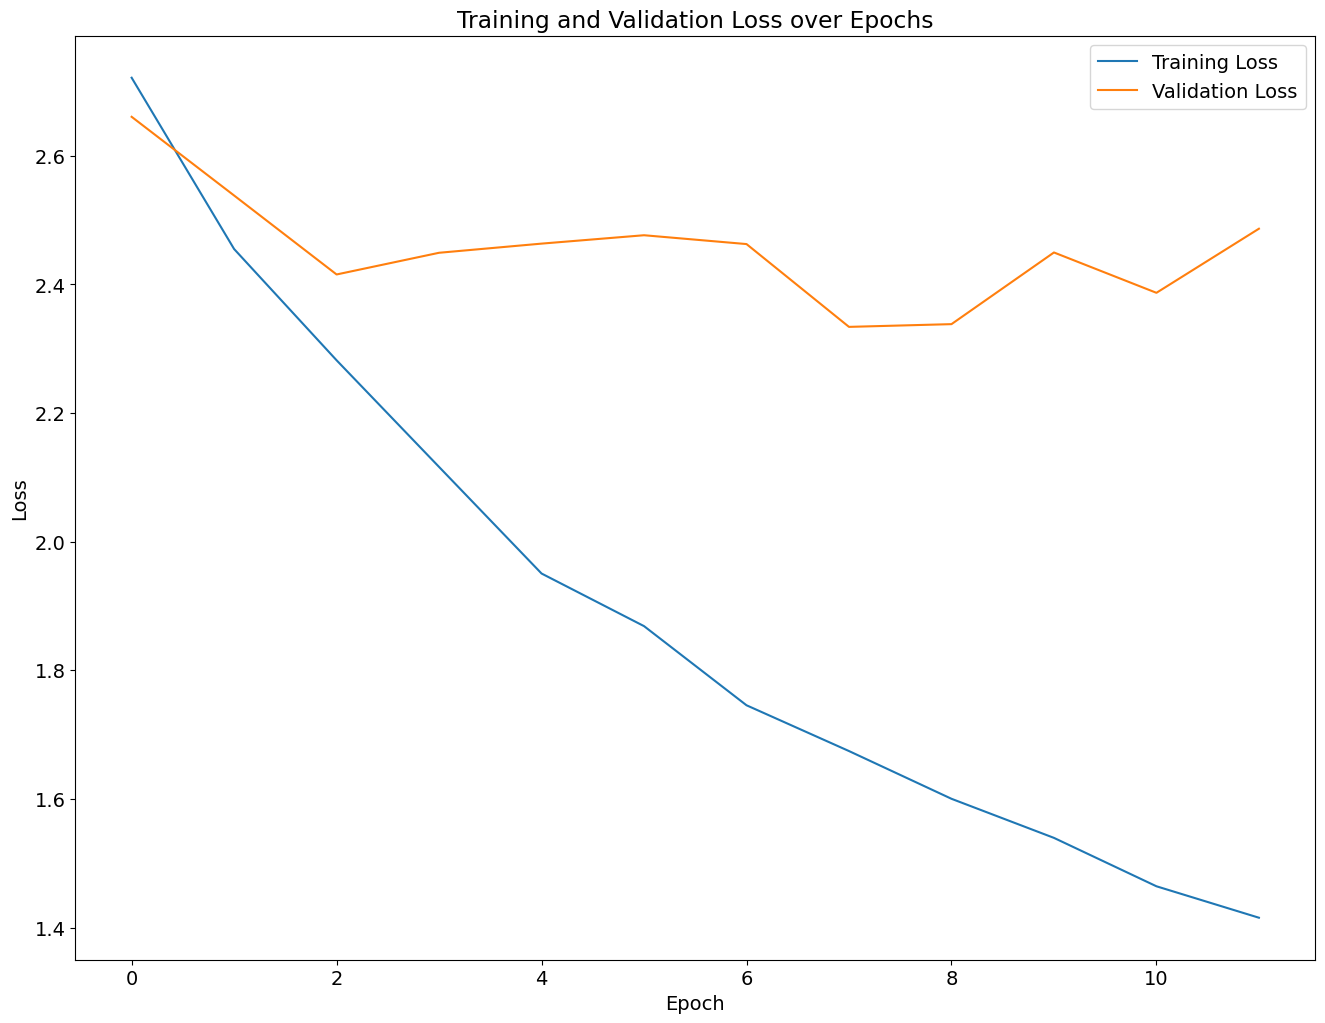

In [ ]:
from torch.nn.utils import clip_grad_norm_
from torch.utils.tensorboard import SummaryWriter
from tqdm.auto import tqdm, trange

import torch.nn.functional as F
import random

writer = SummaryWriter()

n_epochs = 12
clip = 1
global_step = 0  
train_losses = []  
val_losses = []  

for epoch in trange(n_epochs, desc="Epochs"):
    model.train()
    train_loss = 0
    for batch in tqdm(train_iterator, desc="Train", leave=False):

        src, trg = batch.src.to(device), batch.trg.to(device)
        output = model(src, trg)

        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)

        loss = criterion(output, trg)
        optimizer.zero_grad()
        loss.backward()
        clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        train_loss += loss.item()
        writer.add_scalar("Training/loss", loss.item(), global_step)
        global_step += 1

    train_loss /= len(train_iterator)
    writer.add_scalar("Evaluation/train_loss", train_loss, epoch)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in tqdm(valid_iterator, desc="Val", leave=False):

            src, trg = batch.src.to(device), batch.trg.to(device)
            output = model(src, trg)

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            loss = criterion(output, trg)

            val_loss += loss.item()

    val_loss /= len(valid_iterator)
    writer.add_scalar("Evaluation/val_loss", val_loss, epoch)
    val_losses.append(val_loss)

import matplotlib.pyplot as plt

plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs")
plt.show()


__Let's take a look at our network quality__:

In [7]:
!wget https://github.com/mohammadsanaee/DeepLearningCourse/blob/main/utils.py

--2023-05-01 16:23:40--  https://github.com/mohammadsanaee/DeepLearningCourse/blob/main/utils.py
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘utils.py’

utils.py                [ <=>                ] 157.78K  --.-KB/s    in 0.02s   

2023-05-01 16:23:40 (6.43 MB/s) - ‘utils.py’ saved [161567]



In [ ]:
import utils
import imp
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

In [ ]:
batch = next(iter(test_iterator))

In [ ]:
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: shuttle service is provided on request .
Generated: a shuttle service can be arranged on request .

Original: there is a shared kitchen at the property .
Generated: there is a shared kitchen at the property .



In [ ]:
from nltk.translate.bleu_score import corpus_bleu
import tqdm

In [ ]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

59it [00:10,  5.58it/s]


In [ ]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

33.131874314546195

**SUMMARY**

At first the model was trained using only RNN Encoder and Decoder structure.
The Bleu Score was about 14.

In order to improve this score I improve the structure of Encoder and Decoder using Bidirectional GRU. Moreover, I added Attention Mechanism and I found it quite effective for this problem.

The issue I found is that I could not train it for many epochs as I was getting the error that my GPU reached its limit. 

Fortunately I could get the score of 33 which I believe is not the best for a translation model.